In [2]:
confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_cases_url ="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
death_cases_url ="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def get_n_melt_data(data_url,case_type):
    df = pd.read_csv(data_url)
    melted_df = df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'])
    melted_df.rename(columns={"variable":"Date","value":case_type},inplace=True)
    return melted_df

def merge_data(confirm_df,recovered_df,deaths_df):
    new_df = confirm_df.join(recovered_df['Recovered']).join(deaths_df['Deaths'])
    return new_df

In [5]:
confirm_df = get_n_melt_data(confirmed_cases_url,"Confirmed")
recovered_df = get_n_melt_data(recovered_cases_url,"Recovered")
deaths_df = get_n_melt_data(death_cases_url,"Deaths")

In [6]:
confirm_df.tail()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
34309,NaN,Sao Tome and Principe,0.186360,6.613081,5/29/20,463
34310,NaN,Yemen,15.552727,48.516388,5/29/20,283
34311,NaN,Comoros,-11.645500,43.333300,5/29/20,87
34312,NaN,Tajikistan,38.861034,71.276093,5/29/20,3686
34313,NaN,Lesotho,-29.609988,28.233608,5/29/20,2


In [7]:
df = merge_data(confirm_df,recovered_df,deaths_df)

In [8]:
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Recovered,Deaths
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0.0,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0.0,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0.0,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0.0,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0.0,0


In [9]:
df_per_day = df.groupby("Date")[['Confirmed','Recovered', 'Deaths']].sum()

In [10]:
df_per_day

,Confirmed,Recovered,Deaths
Date,,,
1/22/20,555,28.0,17
1/23/20,654,30.0,18
1/24/20,941,36.0,26
1/25/20,1434,43.0,42
1/26/20,2118,102.0,56
...,...,...,...
5/5/20,3662691,1428392.0,257239
5/6/20,3756069,1671443.0,263855
5/7/20,3845718,1539028.0,269567


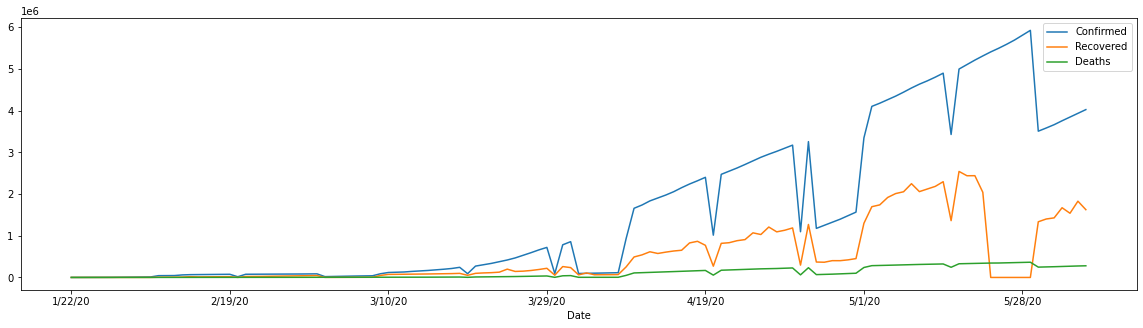

In [11]:
df_per_day.plot(kind='line',figsize=(20,5))

In [12]:
import fbprophet
from fbprophet import Prophet
m = Prophet()

In [13]:
m.add_seasonality(name="monthly",period=30.5,fourier_order=5)

In [14]:
global_cases = df_per_day.reset_index()

In [15]:
confirmed_cases = global_cases[["Date","Confirmed"]]
recovered_cases = global_cases[["Date","Recovered"]]
total_deaths = global_cases[["Date","Deaths"]]

In [16]:
confirmed_cases.rename(columns={"Date":"ds","Confirmed":"y"},inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [17]:
recovered_cases.rename(columns={"Date":"ds","Recovered":"y"},inplace=True)

In [18]:
total_deaths.rename(columns={"Date":"ds","Deaths":"y"},inplace=True)

In [20]:
train = confirmed_cases[:40]
test = confirmed_cases[40:]

In [21]:
train

,ds,y
0,1/22/20,555
1,1/23/20,654
2,1/24/20,941
3,1/25/20,1434
4,1/26/20,2118
5,1/27/20,2927
6,1/28/20,5578
7,1/29/20,6166
8,1/30/20,8234
9,1/31/20,9927


In [22]:
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
future_dates = m.make_future_dataframe(periods=50)

In [24]:
prediction =  m.predict(future_dates)

In [25]:
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-196.539022,-1422.124452,1115.263541
1,2020-01-23,971.092548,-383.937608,2476.463405
2,2020-01-24,501.788492,-934.553120,1884.066145
3,2020-01-25,476.198213,-942.662978,1832.037331
4,2020-01-26,2065.613422,706.165077,3436.226213
...,...,...,...,...
85,2020-04-16,228250.214070,226934.984693,229763.246509
86,2020-04-17,230156.743321,228607.430062,231551.775564
87,2020-04-18,230234.393328,228860.733029,231571.297530
88,2020-04-19,231081.909951,229731.534392,232516.103262


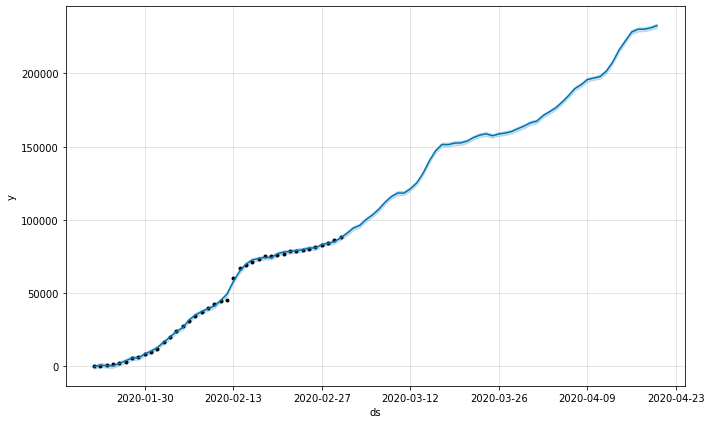

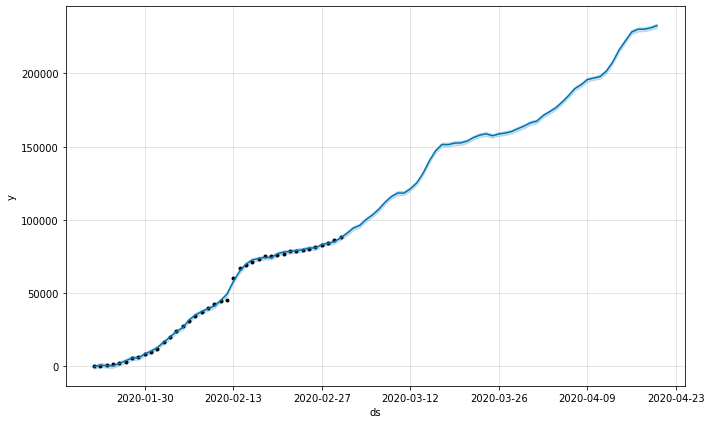

In [26]:
m.plot(prediction)

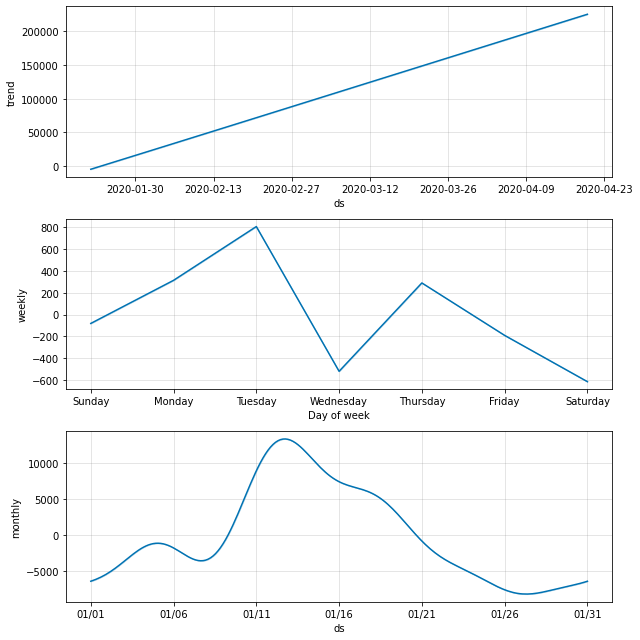

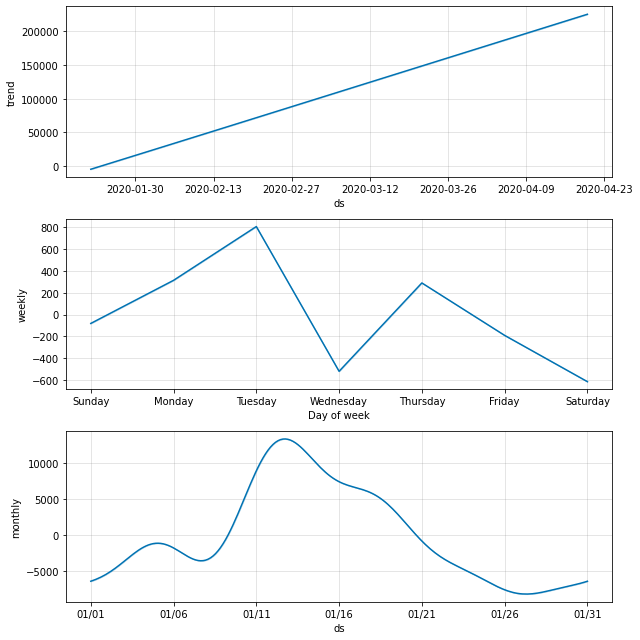

In [27]:
m.plot_components(prediction)

In [28]:
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [29]:
trace = go.Scatter(
    name = 'Daily Death Toll',
    mode = 'markers',
    x = list(prediction['ds']),
    y = list(total_deaths['y']),
    marker=dict(
        color='#FFBAD2',
        line=dict(width=1)
    )
)

In [30]:
trace1 = go.Scatter(
    name = 'trend',
    mode = 'lines',
    x = list(prediction['ds']),
    y = list(prediction['yhat']),
    marker=dict(
        color='red',
        line=dict(width=3)
    )
)

In [31]:
upper_band = go.Scatter(
    name = 'upper band',
    mode = 'lines',
    x = list(prediction['ds']),
    y = list(prediction['yhat_upper']),
    line= dict(color='#57b88f'),
    fill = 'tonexty'
)

In [32]:
lower_band = go.Scatter(
    name= 'lower band',
    mode = 'lines',
    x = list(prediction['ds']),
    y = list(prediction['yhat_lower']),
    line= dict(color='#1705ff')
)


In [ ]:
tracex = go.Scatter(
    name = 'Actual price',
   mode = 'markers',
   x = list(df0['ds']),
   y = list(df0['y']),
   marker=dict(
      color='black',
      line=dict(width=2)
   )
)

In [33]:
data = [ trace1, lower_band, upper_band, trace]

layout = dict(title='Global Death Projection from Covid19',
             xaxis=dict(title = 'Dates', ticklen=2, zeroline=True),
             yaxis=dict(title = 'Total Deaths', ticklen=2, zeroline=True))

figure=dict(data=data,layout=layout)

In [34]:
py.offline.iplot(figure)
plt.show()

In [75]:
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls


In [76]:
username = 'caustin9' 
api_key = 'pkpoOl08miuMbb5edfth' 
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [77]:
import chart_studio.plotly as py
py.plot(figure, filename = 'fb_plot1', auto_open=True)

'https://plotly.com/~caustin9/2/'

In [78]:
tls.get_embed('https://plotly.com/~caustin9/2/')

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~caustin9/2.embed" height="525" width="100%"></iframe>'